This example aims to demonstrate our detection method step-by-step for the user, so they have a firm understanding of how the process works and can easily run it with their own data. In it we detect defects in a single segmented image where the centroid cordinates and cell orientations have already been extracted. 

This mirrors the script 'detect_defects' but for a single image, with intervening results plotted and some of the subroutines in 'functions' also explicitly shown for clarity.

In [27]:
import os
import numpy as np
import functions as f
from tensorflow import keras
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

grid_space = 0.2                                 #Choose spacing of interpolation grid
data_filepath = './CellFiles/cell_data.txt'      #Location of cell coordinate data
save_filepath = '.'                              #Path to where defect folders will be located
posdef_path = save_filepath + '/DefectFiles'     #Location of +1/2 defect files
negdef_path = save_filepath + '/DefectFiles'     #Location of -1/2 defect files
angles = True                                    #Whether to save the detected defects orientation along with position 

#Load CNN model
model_filepath = './SavedModel'
model = keras.models.load_model(model_filepath)

#Load experimental data
file = data_filepath + '/cell_data.txt'

In the script 'detect_defects' the function DetectDefects is now called in a loop as defects are detected in each image and their coordinates are returned as the variable pos_def and neg_def. Here we break down DetectDefects and show how it works step-by-step.

We first load the x and y coordinates of each cell's centroid, as well as its orientation.

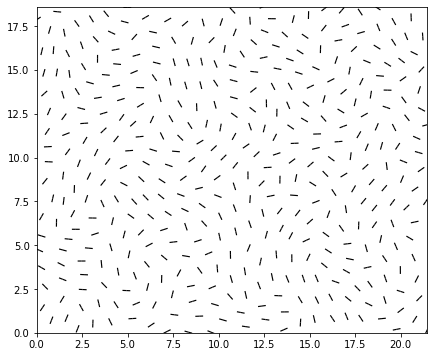

In [36]:
cell_data = np.loadtxt(data_filepath, delimiter = ',')
cell_data[cell_data[:,2]<0,2] += np.pi

x = cell_data[:,0]
y = cell_data[:,1]
theta = cell_data[:,2]

x_max = max(x)
y_max = max(y)

plt.rcParams['figure.figsize'] = [7, 6]
plt.quiver(x, y, 0.1*np.cos(theta), 0.1*np.sin(theta), scale = 10, headlength=0,headaxislength=0)
plt.quiver(x, y, -0.1*np.cos(theta), -0.1*np.sin(theta), scale = 10, headlength=0,headaxislength=0)
plt.xlim((0,x_max))
plt.ylim((0,y_max))
plt.show()

We now interpolate this data to a fine grid using GridDirectors, which also smooths the data out using a sliding window with sides of length 2 * offset.

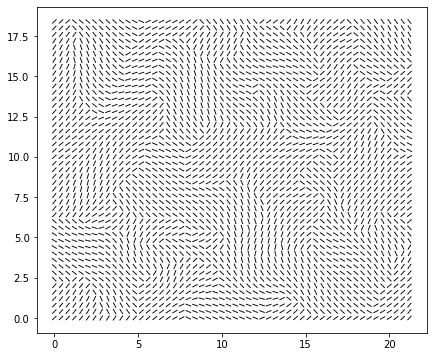

In [32]:
offset = 4
yg, xg = np.mgrid[0:y_max:grid_space,0:x_max:grid_space]

tg = f.GridDirectors(cell_data,xg,yg,offset)

xg_plot = xg[::2,::2]
yg_plot = yg[::2,::2]
tg_plot = tg[::2,::2]

plt.quiver(xg_plot, yg_plot, 0.075*np.cos(tg_plot), 0.075*np.sin(tg_plot), scale = 10, headlength=0,headaxislength=0)
plt.quiver(xg_plot, yg_plot, -0.075*np.cos(tg_plot), -0.075*np.sin(tg_plot), scale = 10, headlength=0,headaxislength=0)
plt.show()

We now use SFinder to calculate the scalar nematic order parameter across the domain and use it to indentify regions of low nematic order (which we define as S < 0.15). We then define the centres of mass of these regions as 'points of interest' (POIs) which fom the centre of 'regions of interest' (ROIs) which we feed into our model to classify.

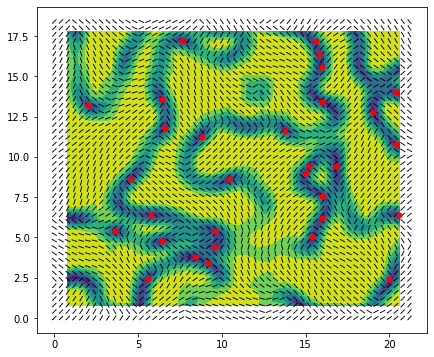

In [33]:
S = f.SFinder(grid_t,offset)
POIs,ROIs = f.ROIFinder(data_filepath,grid_space)
#Plot S and POIs
plt.contourf(xg[offset:-offset,offset:-offset],yg[offset:-offset,offset:-offset],S)
plt.quiver(xg_plot, yg_plot, 0.075*np.cos(tg_plot), 0.075*np.sin(tg_plot), scale = 10, headlength=0,headaxislength=0)
plt.quiver(xg_plot, yg_plot, -0.075*np.cos(tg_plot), -0.075*np.sin(tg_plot), scale = 10, headlength=0,headaxislength=0)
plt.plot(POIs[:,0],POIs[:,1],'ro',ms=5)
plt.show()

#Plot ROIs
#plt.plot(...)

Now use the trained model to classify the ROIs. If 'angles' is set to true we also find the orientation of each defect, which is appended as a third column to pos_defs and neg_defs.

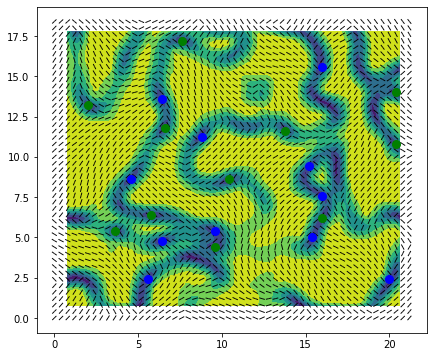

In [34]:
label_prob = model.predict(ROIs,verbose=0)
labels = np.eye(3,dtype=int)[np.argmax(label_prob,axis=1)]
#Use labels to find coordinates of detected defects
pos_defs = POIs[labels[:,2]==1,:];
neg_defs = POIs[labels[:,0]==1,:];
#Find the orientation of defects (if desired)
if angles:
    pos_ROIs = ROIs[labels[:,2]==1,:,:];
    neg_ROIs = ROIs[labels[:,0]==1,:,:];

    pos_angles = f.DefectOrientator(pos_ROIs,0.5,grid_space)
    neg_angles = f.DefectOrientator(neg_ROIs,-0.5,grid_space)

    pos_defs = np.hstack((pos_defs,pos_angles))
    neg_defs = np.hstack((neg_defs,neg_angles))
        
plt.contourf(xg[offset:-offset,offset:-offset],yg[offset:-offset,offset:-offset],S)
plt.quiver(xg_plot, yg_plot, 0.075*np.cos(tg_plot), 0.075*np.sin(tg_plot), scale = 10, headlength=0,headaxislength=0)
plt.quiver(xg_plot, yg_plot, -0.075*np.cos(tg_plot), -0.075*np.sin(tg_plot), scale = 10, headlength=0,headaxislength=0)
plt.plot(pos_defs[:,0],pos_defs[:,1],'bo',ms=8)
plt.plot(neg_defs[:,0],neg_defs[:,1],'go',ms=8)
plt.show()

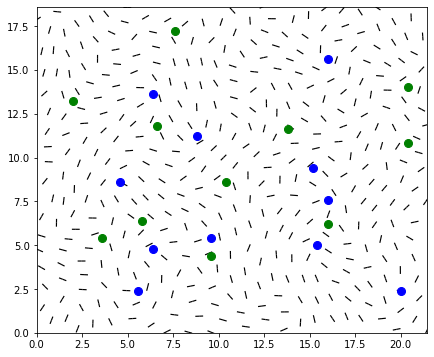

In [35]:
plt.quiver(cell_data[:,0], cell_data[:,1], 0.1*np.cos(theta), 0.1*np.sin(theta), scale = 10, headlength=0,headaxislength=0)
plt.quiver(cell_data[:,0], cell_data[:,1], -0.1*np.cos(theta), -0.1*np.sin(theta), scale = 10, headlength=0,headaxislength=0)
plt.plot(pos_defs[:,0],pos_defs[:,1],'bo',ms=8)
plt.plot(neg_defs[:,0],neg_defs[:,1],'go',ms=8)
plt.xlim((0,x_max))
plt.ylim((0,y_max))
plt.show()

We now save the detected defect coordinates (and orientation) to the locations specified.

In [28]:
image_num = 1 

filename = 'posdefects%06d.txt' % image_num
np.savetxt(os.path.join(posdef_path, filename),pos_defs, delimiter=',')
filename = 'negdefects%06d.txt' % image_num
np.savetxt(os.path.join(negdef_path, filename),neg_defs, delimiter=',')